In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA


In [3]:
def center_and_scale(X, with_std=True):
    mu = np.mean(X, axis=0)
    Xc = X - mu
    if with_std:
        sigma = Xc.std(axis=0, ddof=1)
        sigma[sigma == 0] = 1.0
        Xcs = Xc / sigma
        return Xcs, mu, sigma
    return Xc, mu, None

In [4]:
def reconstruction_error(X_orig, X_recon):
    return np.mean(np.sum((X_orig - X_recon) ** 2, axis=1))

def pca_svd(X, n_components):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    components = Vt[:n_components]
    scores = U[:, :n_components] * S[:n_components]
    explained_variance = (S ** 2) / (X.shape[0] - 1)
    return {
        'components': components,
        'scores': scores,
        'singular_values': S,
        'explained_variance': explained_variance,
        'Vt': Vt
    }

In [5]:
def ppca_em(X, n_components, n_iter=100, tol=1e-6, verbose=False):
    n_samples, d = X.shape
    mu = np.mean(X, axis=0)
    Xc = X - mu
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    W = Vt[:n_components].T * np.sqrt(S[:n_components] ** 2 / (n_samples - 1))
    sigma2 = np.mean(S[n_components:] ** 2) / (n_samples - 1) if n_components < d else 1e-6
    Iq = np.eye(n_components)
    prev_ll = -np.inf
    for i in range(n_iter):
        M = W.T @ W + sigma2 * Iq
        M_inv = np.linalg.inv(M)
        Ez = Xc @ W @ M_inv
        Ezz = sigma2 * M_inv + np.einsum('ni,nj->nij', Ez, Ez)
        sum_xz = Xc.T @ Ez
        sum_zz = Ezz.sum(axis=0)
        W_new = sum_xz @ np.linalg.inv(sum_zz)
        recon = np.trace(Xc @ Xc.T) - 2 * np.trace(W_new @ sum_xz.T) + np.trace(W_new @ sum_zz @ W_new.T)
        sigma2_new = recon / (n_samples * d)
        W, sigma2 = W_new, sigma2_new
        C = W @ W.T + sigma2 * np.eye(d)
        sign, logdet = np.linalg.slogdet(C)
        if sign <= 0:
            ll = -np.inf
        else:
            invC = np.linalg.inv(C)
            ll = -0.5 * n_samples * (d * np.log(2 * np.pi) + logdet) - 0.5 * np.sum(np.sum(Xc * (Xc @ invC), axis=1))
        if np.abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    def transform(Xnew):
        Xn = Xnew - mu
        M = W.T @ W + sigma2 * np.eye(n_components)
        return Xn @ W @ np.linalg.inv(M)

    def inverse_transform(Z):
        return Z @ W.T + mu

    def reconstruct(Xnew):
        return inverse_transform(transform(Xnew))

    return {
        'W': W,
        'sigma2': sigma2,
        'mu': mu,
        'transform': transform,
        'inverse_transform': inverse_transform,
        'reconstruct': reconstruct,
        'log_likelihood': prev_ll
    }

In [6]:
def demo_pca_vs_ppca_on_digits(n_components=16):
    digits = datasets.load_digits()
    X = digits.data
    Xs, mu, sigma = center_and_scale(X, with_std=True)
    pca = pca_svd(Xs, n_components=n_components)
    ev = pca['explained_variance']
    plt.figure(figsize=(6,3))
    plt.plot(ev[:50], marker='o')
    plt.title('Scree plot: leading eigenvalues (digits)')
    plt.xlabel('Component index')
    plt.ylabel('Eigenvalue')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    Vt = pca['Vt']
    U = (Xs @ Vt.T)
    S = pca['singular_values']
    k = n_components
    X_recon_pca = (U[:, :k] * S[:k]) @ Vt[:k, :]
    X_recon_pca = X_recon_pca * sigma + mu
    ppca = ppca_em(X, n_components=min(n_components, X.shape[1] - 1), n_iter=200, tol=1e-5, verbose=False)
    X_recon_ppca = ppca['reconstruct'](X)
    err_pca = reconstruction_error(X, X_recon_pca)
    err_ppca = reconstruction_error(X, X_recon_ppca)
    print(f"Reconstruction MSE (PCA k={k}): {err_pca:.4f}")
    print(f"Reconstruction MSE (PPCA q={k}): {err_ppca:.4f}")
    n_show = 6
    fig, axes = plt.subplots(n_show, 3, figsize=(6, 2*n_show))
    for i in range(n_show):
        axes[i,0].imshow(X[i].reshape(8,8), cmap='gray')
        axes[i,0].set_title('Original')
        axes[i,0].axis('off')
        axes[i,1].imshow(X_recon_pca[i].reshape(8,8), cmap='gray')
        axes[i,1].set_title('PCA recon')
        axes[i,1].axis('off')
        axes[i,2].imshow(X_recon_ppca[i].reshape(8,8), cmap='gray')
        axes[i,2].set_title('PPCA recon')
        axes[i,2].axis('off')
    plt.tight_layout()
    plt.show()
    return pca, ppca

def demo_component_scatter_with_moons():
    X, y = datasets.make_moons(n_samples=500, noise=0.08, random_state=0)
    Xs, mu, sigma = center_and_scale(X, with_std=True)
    p = pca_svd(Xs, n_components=2)
    proj = Xs @ p['components'].T
    plt.figure(figsize=(6,4))
    plt.scatter(proj[:,0], proj[:,1], c=y, s=20)
    plt.title('Data projected onto first two PCA components (make_moons)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()
    return p

In [7]:
def demo_ica_with_blobs(n_sources=3):
    Xs, _ = datasets.make_blobs(n_samples=1000, centers=n_sources, n_features=n_sources, random_state=42)
    Xs, mu_s, sigma_s = center_and_scale(Xs, with_std=True)
    rng = np.random.RandomState(0)
    A = rng.randn(n_sources, n_sources)
    X_mixed = Xs @ A.T
    ica = FastICA(n_components=n_sources, random_state=0, max_iter=1000)
    S_est = ica.fit_transform(X_mixed)
    A_est = ica.mixing_
    fig, axes = plt.subplots(3, 1, figsize=(8, 6))
    for i, arr in enumerate([Xs[:,0], X_mixed[:,0], S_est[:,0]]):
        axes[i].plot(arr)
        axes[i].set_ylabel(['orig', 'mixed', 'recovered'][i])
    plt.suptitle('Original vs Mixed vs ICA Recovered')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    plt.scatter(X_mixed[:,0], X_mixed[:,1], s=8, alpha=0.6)
    plt.title('Mixed signals')
    plt.xlabel('mixed 0')
    plt.ylabel('mixed 1')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    plt.scatter(S_est[:,0], S_est[:,1], s=8, alpha=0.6)
    plt.title('ICA recovered components')
    plt.xlabel('ICA 0')
    plt.ylabel('ICA 1')
    plt.tight_layout()
    plt.show()
    return {'original_sources': Xs, 'mixed': X_mixed, 'recovered': S_est, 'mixing_matrix': A, 'estimated_mixing': A_est}

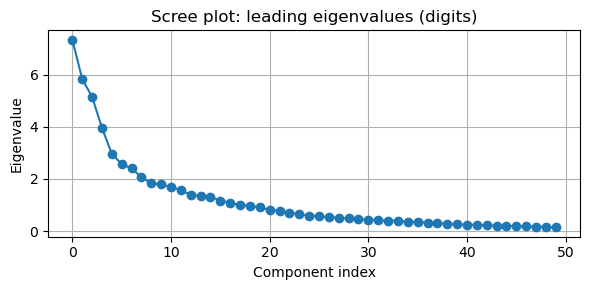

Reconstruction MSE (PCA k=16): 6854127.6746
Reconstruction MSE (PPCA q=16): 187.1056


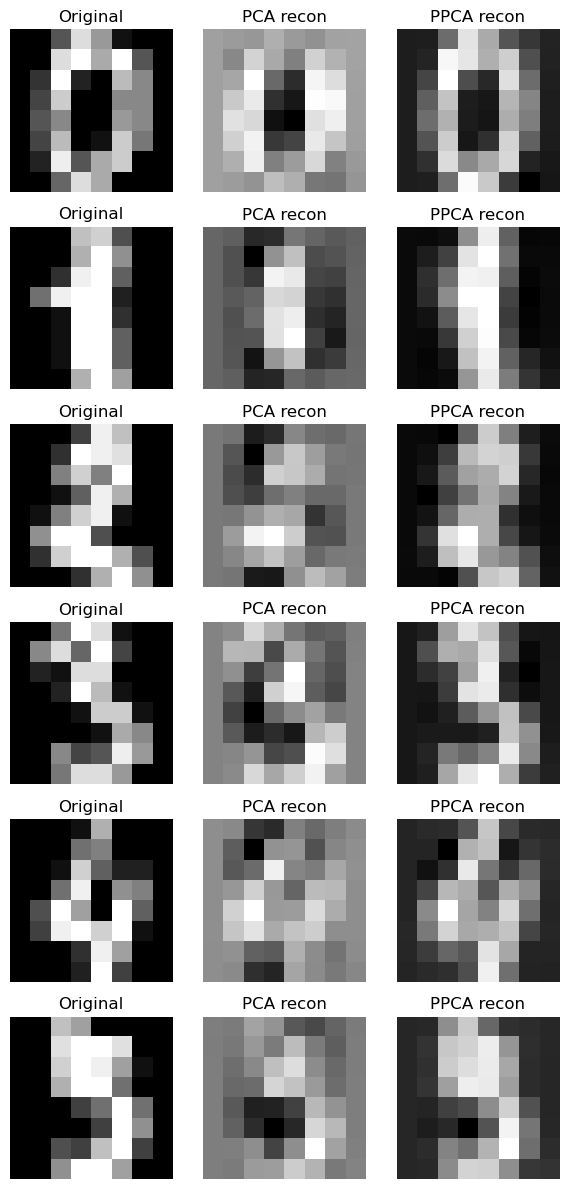

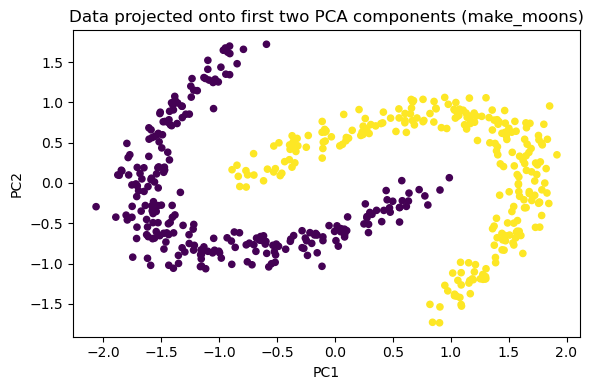

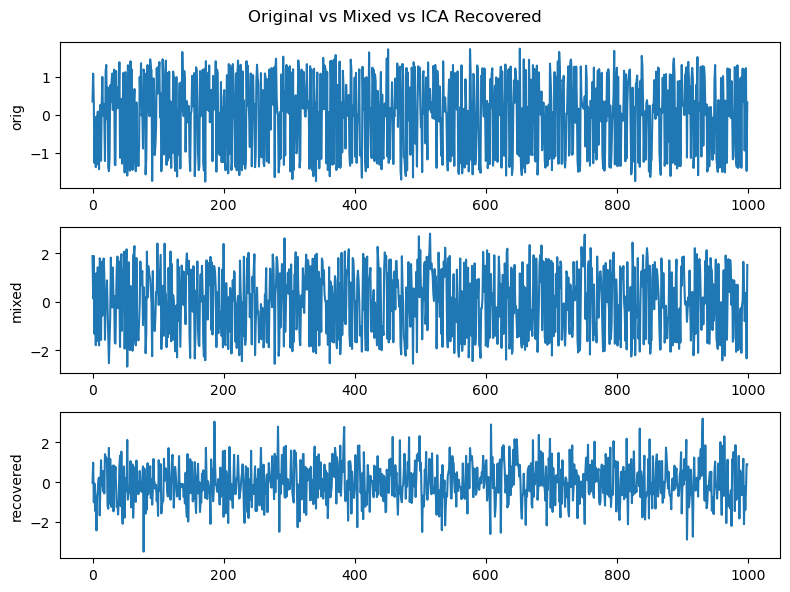

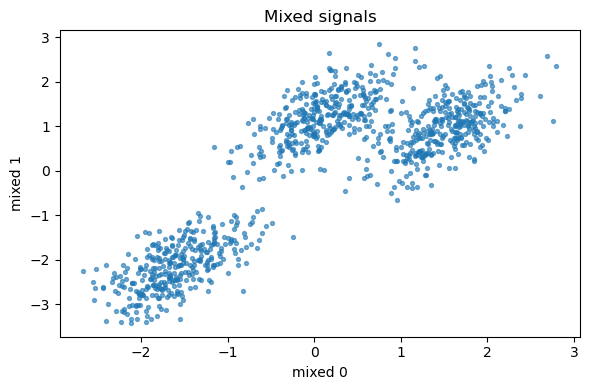

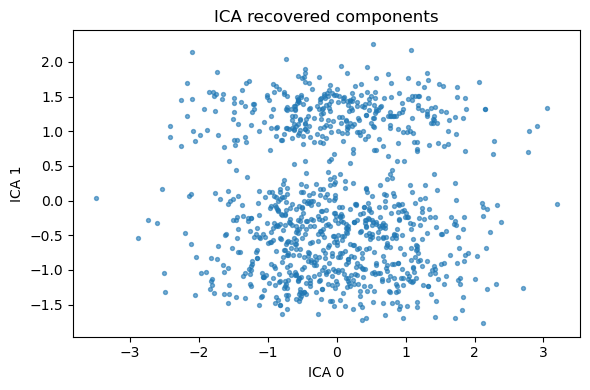

In [8]:
pca_result, ppca_result = demo_pca_vs_ppca_on_digits(n_components=16)
pca_proj = demo_component_scatter_with_moons()
ica_res = demo_ica_with_blobs(n_sources=3)
